### Question: does `model` returns `[0 prob, 1 prob]` before softmax?

In [1]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    AutoConfig,
    TextClassificationPipeline,
)
from engine.data import prepare_data_for_fine_tuning, read_data
from engine.xai import FeatureAblationText
import pandas as pd
from engine.ner_detector import text_preprocess

c:\Users\1234o\Studies\Sem2\NLP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_ID = "roberta-base"
MODEL_PATH = "output/checkpoint-2025/model.safetensors"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

In [3]:
test = pd.read_csv("data/isot/test.csv")
test['text'] = text_preprocess(test['text'].to_list())
print(test)
test_dataset = prepare_data_for_fine_tuning(test, tokenizer)

                                                   text  label
0     U.S. House approves disaster funds as Trump cr...      0
1     Nine Republican senators urge Trump to pursue ...      0
2     Obama Makes UNPRECEDENTED Move To Protect The ...      1
3     Conservative Icon And National Review Founder ...      1
4     ICYMI: Seth Meyers Rips Apart Email from Paul ...      1
...                                                 ...    ...
8975  G4S suspends nine staff at UK migrant center, ...      0
8976  U.S. will only talk to North Korea about freei...      0
8977  Ukraine's Poroshenko vows to work for quick ex...      0
8978  TRUMP HITS BACK After News of North Korea's Nu...      1
8979  Kremlin: U.S. sanctions aimed at turning busin...      0

[8980 rows x 2 columns]


Map: 100%|██████████| 8980/8980 [00:03<00:00, 2300.80 examples/s]


In [4]:
import torch
def get_device():
    if torch.cuda.is_available():
        print("CUDA is available. Using GPU.")
        return "cuda"
    else:
        print("CUDA not available. Using CPU.")
        return "cpu"

In [5]:
config = AutoConfig.from_pretrained(MODEL_ID)
device = get_device()
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH, config=config
)
model.eval()
pipeline = TextClassificationPipeline(
    model=model, tokenizer=tokenizer, top_k=2, device=device
)

CUDA not available. Using CPU.


In [6]:
%%capture
if(device == "cuda"):
    model.cuda()
else:
    model.cpu()

In [7]:
obs = test["text"].tolist()[1]
if(device == "cuda"):
    obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cuda()
else:
    obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cpu()

print(obs)
print(obs_pt)


Nine Republican senators urge Trump to pursue tough Russia policy
tensor([[    0, 37071,  1172,  7028,  8745,   140,     7,  5445,  1828,   798,
           714,     2]])


In [8]:
test["text"].tolist()[1]

'Nine Republican senators urge Trump to pursue tough Russia policy'

In [9]:
def forward(obs):
    return model(obs).logits

In [10]:

attr = FeatureAblationText(forward)
print(attr)
exp = attr.get_attributions([obs_pt])
exp

tensor([[[ 0.0000e+00,  4.2170e-06,  4.0680e-06,  4.6194e-06,  2.8014e-06,
           6.0052e-06,  4.3511e-06,  1.5795e-06,  2.8610e-06,  3.9935e-06,
           4.8131e-06,  3.8892e-06],
         [ 0.0000e+00, -3.7253e-08,  1.8068e-06,  1.6764e-06,  2.2501e-06,
           3.5651e-06,  2.1514e-06,  1.0394e-06,  1.8328e-06,  3.1609e-06,
           2.2277e-06,  1.7826e-06]]])

In [11]:
tokens = pipeline.tokenizer.convert_ids_to_tokens(obs_pt[0])
print(tokens)

['<s>', 'Nine', 'ĠRepublican', 'Ġsenators', 'Ġurge', 'ĠTrump', 'Ġto', 'Ġpursue', 'Ġtough', 'ĠRussia', 'Ġpolicy', '</s>']


In [12]:
import spacy

NER = spacy.load("en_core_web_sm")

doc = NER(obs)

print("Entities in the text:")
for ent in doc.ents:
    print(f"{ent.text} ({ent.label_}) - {spacy.explain(ent.label_)}")

Entities in the text:
Nine (CARDINAL) - Numerals that do not fall under another type
Republican (NORP) - Nationalities or religious or political groups
Trump (ORG) - Companies, agencies, institutions, etc.
Russia (GPE) - Countries, cities, states


In [13]:
print("\nTokens and Their NER Information: \n")

for token in doc:
    if token.ent_type_:
        print(f"Token: {token.text}, Entity Type: {token.ent_type_} ({spacy.explain(token.ent_type_)})")
    else:
        print(f"Token: {token.text}, Not part of any entity.")


Tokens and Their NER Information: 

Token: Nine, Entity Type: CARDINAL (Numerals that do not fall under another type)
Token: Republican, Entity Type: NORP (Nationalities or religious or political groups)
Token: senators, Not part of any entity.
Token: urge, Not part of any entity.
Token: Trump, Entity Type: ORG (Companies, agencies, institutions, etc.)
Token: to, Not part of any entity.
Token: pursue, Not part of any entity.
Token: tough, Not part of any entity.
Token: Russia, Entity Type: GPE (Countries, cities, states)
Token: policy, Not part of any entity.


In [14]:
print(len(tokens))

tokens_clear = [s.replace("Ġ", "") for s in tokens]
tokens_clear = tokens_clear[1:len(tokens_clear)-1]
print(tokens_clear)

print(exp)
print(len(exp))

12
['Nine', 'Republican', 'senators', 'urge', 'Trump', 'to', 'pursue', 'tough', 'Russia', 'policy']
tensor([[[ 0.0000e+00,  4.2170e-06,  4.0680e-06,  4.6194e-06,  2.8014e-06,
           6.0052e-06,  4.3511e-06,  1.5795e-06,  2.8610e-06,  3.9935e-06,
           4.8131e-06,  3.8892e-06],
         [ 0.0000e+00, -3.7253e-08,  1.8068e-06,  1.6764e-06,  2.2501e-06,
           3.5651e-06,  2.1514e-06,  1.0394e-06,  1.8328e-06,  3.1609e-06,
           2.2277e-06,  1.7826e-06]]])
1


In [15]:
from engine.tokens_aggregate import TokenAggregate

In [16]:
aggregate_list = TokenAggregate.generate_aggregate_list(doc,exp[0],tokens_clear,tokens)

In [18]:
from engine.xai import FeatureAblation
from engine.tokens_aggregate import TokenAggregate
from engine.ner_detector import tokenize_evaluate_and_detect_NERs,generate_aggregates

all_aggregate = generate_aggregates(pipeline,[test["text"].tolist()[1156]])

1it [00:02,  2.43s/it]


In [19]:
print(all_aggregate)

[[<engine.tokens_aggregate.TokenAggregate object at 0x000002F72AA0D9D0>, <engine.tokens_aggregate.TokenAggregate object at 0x000002F72B7ACF80>, <engine.tokens_aggregate.TokenAggregate object at 0x000002F72AA0C800>, <engine.tokens_aggregate.TokenAggregate object at 0x000002F72AA0D520>, <engine.tokens_aggregate.TokenAggregate object at 0x000002F72AA0DA60>, <engine.tokens_aggregate.TokenAggregate object at 0x000002F72AA0C530>, <engine.tokens_aggregate.TokenAggregate object at 0x000002F72AA0D5E0>, <engine.tokens_aggregate.TokenAggregate object at 0x000002F72AA0E660>, <engine.tokens_aggregate.TokenAggregate object at 0x000002F72AA0C8F0>, <engine.tokens_aggregate.TokenAggregate object at 0x000002F72AA0CAA0>, <engine.tokens_aggregate.TokenAggregate object at 0x000002F72AA0C4A0>, <engine.tokens_aggregate.TokenAggregate object at 0x000002F72AA0D130>, <engine.tokens_aggregate.TokenAggregate object at 0x000002F72AA0CE90>, <engine.tokens_aggregate.TokenAggregate object at 0x000002F72AA0DCA0>, <eng

In [20]:
for doc_aggreagtes in all_aggregate:
    for aggregate in doc_aggreagtes:
        # if(len(aggregate.spacy_token)>1):
        print(aggregate)

Is spacy NER: ['GPE']
spacy token: ['FRANCE']
Our model clean: ['FR', 'ANCE']
Our model dirty: ['FR', 'ANCE']
model exp: [-8.344650268554688e-07, -1.2218952178955078e-06]

Is spacy NER: ['']
spacy token: [':']
Our model clean: [':']
Our model dirty: [':']
model exp: [-2.7567148208618164e-06]

Is spacy NER: ['']
spacy token: ['"']
Our model clean: ['"']
Our model dirty: ['Ġ"']
model exp: [-2.2649765014648438e-06]

Is spacy NER: ['WORK_OF_ART']
spacy token: ['Topless']
Our model clean: ['Top', 'less']
Our model dirty: ['Top', 'less']
model exp: [-2.2798776626586914e-06, -4.559755325317383e-06]

Is spacy NER: ['WORK_OF_ART']
spacy token: ['Trump']
Our model clean: ['Trump']
Our model dirty: ['ĠTrump']
model exp: [-1.7583370208740234e-06]

Is spacy NER: ['']
spacy token: ['"']
Our model clean: ['"']
Our model dirty: ['"']
model exp: [-1.1771917343139648e-06]

Is spacy NER: ['']
spacy token: ['And']
Our model clean: ['And']
Our model dirty: ['ĠAnd']
model exp: [-1.2814998626708984e-06]

Is 

In [22]:
test = pd.read_csv("data/isot/test.csv")

In [23]:
token_exp_NERs = tokenize_evaluate_and_detect_NERs(pipeline,test["text"].tolist()[253:254],ners_to_calculate_ablation=['PERSON'])

1it [00:00, 1874.13it/s]
100%|██████████| 1/1 [00:00<00:00, 1797.05it/s]
1it [00:00,  8.58it/s]
100%|██████████| 1/1 [00:00<?, ?it/s]


100it [00:00, 19866.92it/s]
100%|██████████| 100/100 [00:00<00:00, 24957.18it/s]
100it [00:12,  8.19it/s]
100%|██████████| 100/100 [00:00<?, ?it/s]


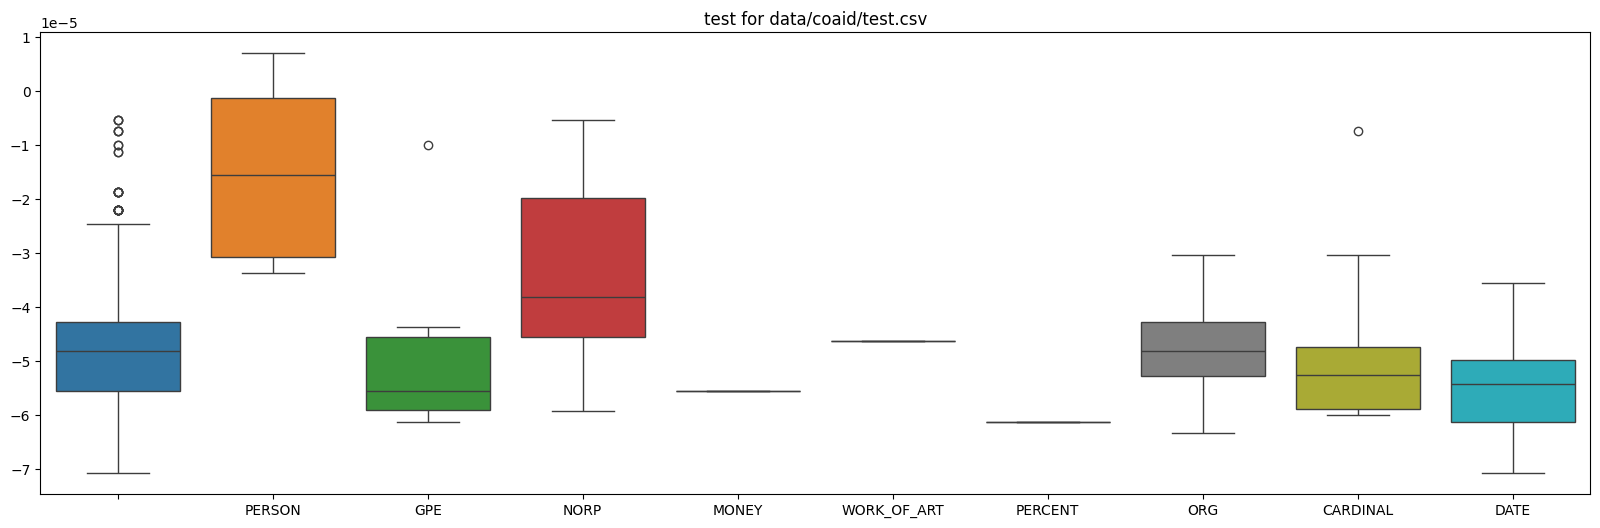

100it [00:00, ?it/s]
100%|██████████| 100/100 [00:00<00:00, 13062.30it/s]
100it [00:14,  6.89it/s]
100%|██████████| 100/100 [00:00<00:00, 345.31it/s]


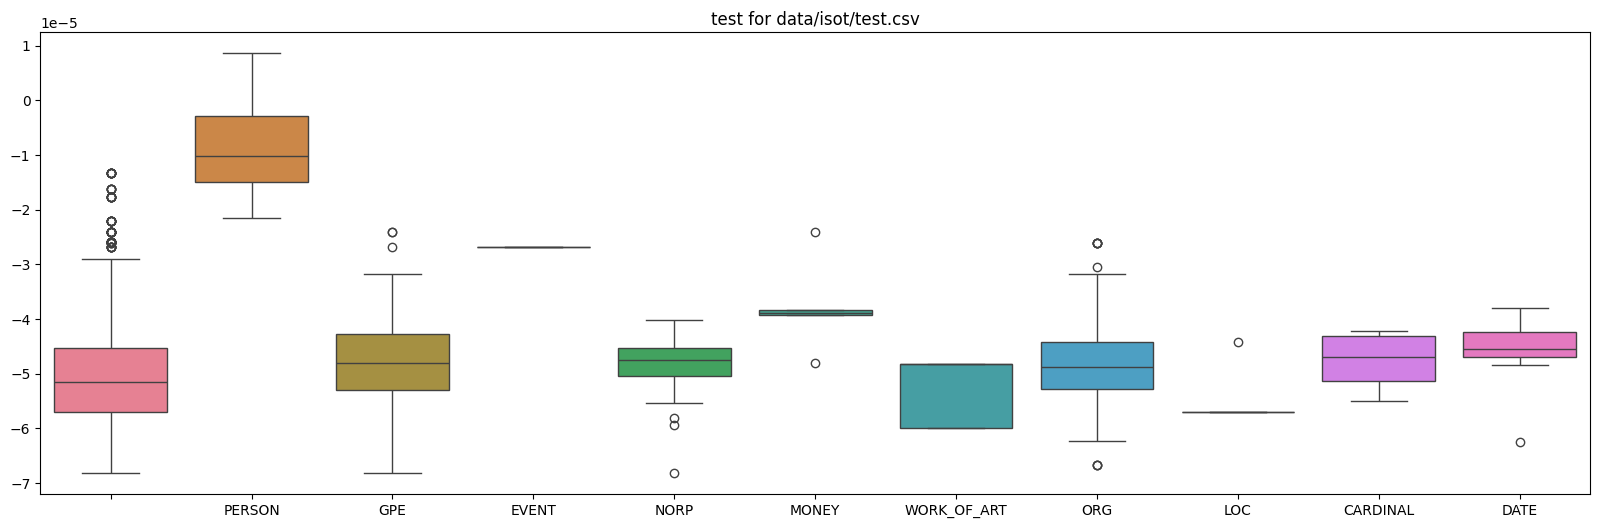

100it [00:00, 19936.80it/s]
100%|██████████| 100/100 [00:00<00:00, 24691.26it/s]
100it [00:14,  6.84it/s]
100%|██████████| 100/100 [00:00<?, ?it/s]


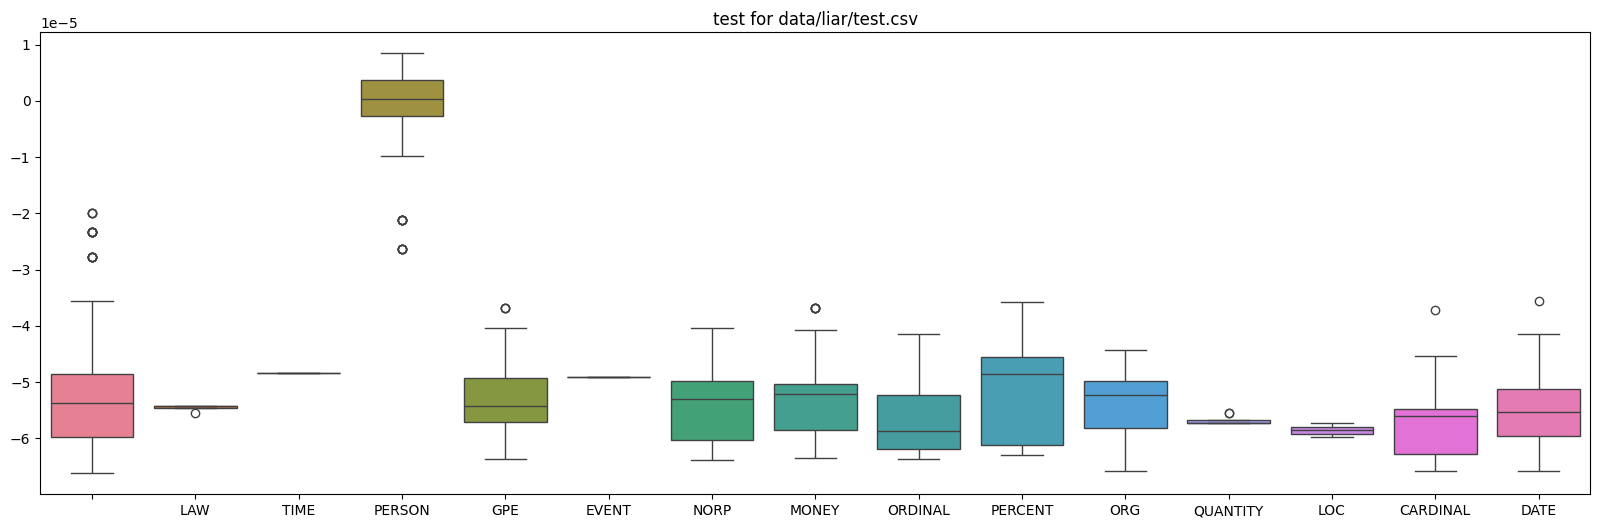

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

tests_files = ["data/coaid/test.csv","data/isot/test.csv","data/liar/test.csv"]
for file in tests_files:
    test = pd.read_csv(file)
    token_exp_NERs = tokenize_evaluate_and_detect_NERs(pipeline,test["text"].tolist(),ners_to_calculate_ablation=['PERSON'])

    all_ner_types = set()

    for _,_,ner in token_exp_NERs:
            all_ner_types.add(ner)
            
    exps = {}
    for ner_type in all_ner_types:
        exps[ner_type] = []



    for token,exp,ner in token_exp_NERs:
        exps[ner].append(exp)


    plt.figure(figsize=(20,6))
    sns.boxplot(exps)
    plt.title(f"test for {file}")
    plt.show()